# Read in Subset of data filtered by xgboost results

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import io

import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
import _pickle as pickle
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
import boto3
s3 = boto3.resource('s3')
with open('cpgs_XGboost_whole_blood_ranked', 'wb') as data:
    s3.Bucket("amp297bucket").download_fileobj("cpg_lists/cpgs_XGboost_whole_blood_ranked", data)

with open('cpgs_XGboost_whole_blood_ranked', 'rb') as data:
    cpg_xgb = pickle.load(data)

In [5]:
cpg_xgb

array(['cg14361627', 'cg16867657', 'cg04875128', ..., 'cg19489320',
       'cg25955850', 'cg12053291'], dtype=object)

In [6]:
cpg_xgb = list(dict.fromkeys(cpg_xgb))
print(len(cpg_xgb))

2224


In [7]:
import s3fs
import boto3
import math
import csv
import re
import pandas as pd

s3 = s3fs.S3FileSystem(anon=False)
bucket='amp297bucket'
data_key = 'age_sample.txt'
data_location = 's3://{}/{}'.format(bucket, data_key)

skipped = []
cpg_ranking = []
i = 0
with s3.open(data_location, 'r') as file_in:
    for row in file_in:
        cpg = row[0:10]
        if cpg not in cpg_xgb and i >= 3:
            skipped.append(i)
        else:
            cpg_ranking.append(cpg)
        if i % 5000 == 0:
            print(i)
        i += 1
#healthy = pd.read_csv(data_location,  delimiter = '\t',nrows=2,low_memory=False)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000


In [8]:
skipped[0:5]

[3, 4, 5, 6, 7]

### Read in data according to the top cpg list

In [9]:
print("Reading data...")
df_subset = pd.read_csv('s3://amp297bucket/age_sample.txt', delimiter = '\t', header = None, 
                        skiprows=skipped, low_memory=False)

Reading data...


In [10]:
df_subset

,0,1,2,3,4,5,6,7,8,9,...,8365,8366,8367,8368,8369,8370,8371,8372,8373,8374
0,sample_id,GSM2139432,GSM2139249,GSM2139398,GSM2139297,GSM1069208,GSM1443489,GSM1069141,GSM1443483,GSM1069172,...,GSM1546403,GSM1546425,GSM1572948,GSM1573032,GSM1871586,GSM1871753,GSM1438255,GSM1438138,GSM1438147,GSM1438204
1,age,71,76,102,108,40,40,59,59,66,...,53,53,53,53,53,53,53.1594,53.3855,53.477,53.477
2,tissue,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,brain - superior temporal gyrus,...,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe,brain - occipital lobe
3,cg00373606,0.026,0.451,0.444,0.404,0.032,0.032,0.031,0.031,0.025,...,0.038,0.439,0.038,0.439,0.038,0.439,0.392,0.026,0.035,0.028
4,cg01814235,0.87,0.806,0.823,0.791,0.895,0.895,0.88,0.88,0.915,...,0.83,0.862,0.831,0.863,0.831,0.863,0.845,0.88,0.889,0.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,cg05794695,0.221,0.208,0.19,0.278,0.296,0.296,0.211,0.211,0.291,...,0.21,0.227,0.224,0.237,0.224,0.237,0.227,0.203,0.19,0.28
817,cg05955036,0.681,0.663,0.692,0.692,0.639,0.639,0.746,0.746,0.696,...,0.688,0.622,0.68,0.622,0.68,0.622,0.66,0.633,0.668,0.638
818,cg06174704,0.462,0.431,0.406,0.531,0.564,0.564,0.515,0.515,0.489,...,0.561,0.559,0.565,0.565,0.565,0.565,0.479,0.529,0.561,0.549
819,cg06335143,0.165,0.139,0.103,0.155,0.075,0.075,0.119,0.119,0.18,...,0.081,0.106,0.076,0.099,0.076,0.099,0.079,0.08,0.072,0.079


In [11]:
# transpose to let cpg be columns
data = df_subset.transpose()

In [12]:
data.columns = data.iloc[0]
data = data[1:]
data.head()

,sample_id,age,tissue,cg00373606,cg01814235,cg04149024,cg10315562,cg11049774,cg16829640,cg18000985,...,cg04912542,cg04984052,cg05135156,cg05308819,cg05625834,cg05794695,cg05955036,cg06174704,cg06335143,cg06437747
1,GSM2139432,71,brain - superior temporal gyrus,0.026,0.87,0.042,0.03,0.01,0.68,0.021,...,0.96,0.345,0.06,0.124,0.892,0.221,0.681,0.462,0.165,0.74
2,GSM2139249,76,brain - superior temporal gyrus,0.451,0.806,0.512,0.512,0.374,0.783,0.012,...,0.942,0.319,0.086,0.14,0.881,0.208,0.663,0.431,0.139,0.697
3,GSM2139398,102,brain - superior temporal gyrus,0.444,0.823,0.489,0.486,0.365,0.695,0.02,...,0.965,0.325,0.056,0.136,0.896,0.19,0.692,0.406,0.103,0.687
4,GSM2139297,108,brain - superior temporal gyrus,0.404,0.791,0.501,0.511,0.416,0.72,0.023,...,0.968,0.348,0.07,0.19,0.911,0.278,0.692,0.531,0.155,0.735
5,GSM1069208,40,brain - superior temporal gyrus,0.032,0.895,0.044,0.015,0.008,0.641,0.031,...,0.981,0.427,0.059,0.17,0.901,0.296,0.639,0.564,0.075,0.803


In [13]:
cpg_ranking

['sample_id\t',
 'age\t71\t76\t',
 'tissue\tbra',
 'cg00373606',
 'cg01814235',
 'cg04149024',
 'cg10315562',
 'cg11049774',
 'cg16829640',
 'cg18000985',
 'cg20279479',
 'cg24976080',
 'cg26621014',
 'cg00298532',
 'cg00311307',
 'cg00999163',
 'cg01074797',
 'cg01101873',
 'cg01413566',
 'cg01428437',
 'cg01803759',
 'cg02494066',
 'cg02931001',
 'cg02998281',
 'cg03397716',
 'cg04158367',
 'cg04158730',
 'cg04289036',
 'cg04299080',
 'cg04791747',
 'cg04917688',
 'cg06784991',
 'cg06804846',
 'cg06931612',
 'cg06955091',
 'cg07103618',
 'cg07181952',
 'cg07201754',
 'cg07202479',
 'cg07346648',
 'cg07418114',
 'cg07795402',
 'cg07813495',
 'cg07901143',
 'cg08262088',
 'cg09036220',
 'cg09036468',
 'cg09252331',
 'cg09255966',
 'cg09271882',
 'cg09362543',
 'cg09765586',
 'cg10115022',
 'cg10146326',
 'cg11072045',
 'cg11224984',
 'cg11412935',
 'cg11852073',
 'cg11987231',
 'cg12219387',
 'cg12267948',
 'cg13204758',
 'cg13806070',
 'cg13947949',
 'cg15007228',
 'cg15014975',
 'cg1

### Let data columns order by cpg rankings for later use

In [15]:
col_order = ['sample_id', 'age', 'tissue']
col_order

['sample_id', 'age', 'tissue']

In [16]:
for item in cpg_xgb:
    if item in cpg_ranking:
        col_order.append(item)

In [17]:
len(col_order)

821

In [18]:
data.columns

Index(['sample_id', 'age', 'tissue', 'cg00373606', 'cg01814235', 'cg04149024',
       'cg10315562', 'cg11049774', 'cg16829640', 'cg18000985',
       ...
       'cg04912542', 'cg04984052', 'cg05135156', 'cg05308819', 'cg05625834',
       'cg05794695', 'cg05955036', 'cg06174704', 'cg06335143', 'cg06437747'],
      dtype='object', name=0, length=821)

In [19]:
data = data[col_order]

### Look at different distributions of data

Text(0, 0.5, 'number of samples')

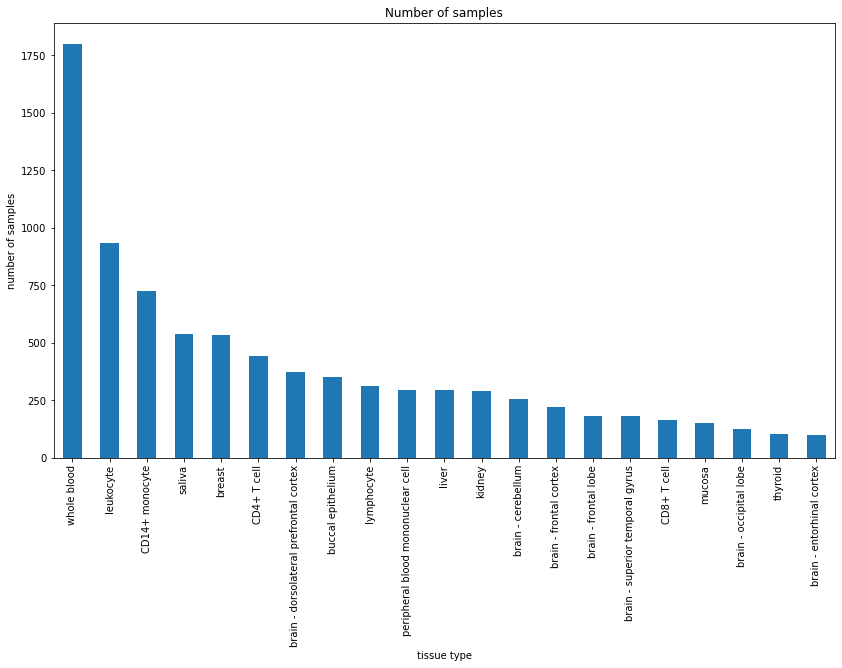

In [20]:
ax = data['tissue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of samples")
ax.set_xlabel("tissue type")
ax.set_ylabel("number of samples")

In [67]:
data['tissue'].value_counts()

whole blood                               1802
leukocyte                                  934
CD14+ monocyte                             724
saliva                                     539
breast                                     535
CD4+ T cell                                443
brain - dorsolateral prefrontal cortex     373
buccal epithelium                          351
lymphocyte                                 313
peripheral blood mononuclear cell          294
liver                                      294
kidney                                     290
brain - cerebellum                         257
brain - frontal cortex                     219
brain - frontal lobe                       182
brain - superior temporal gyrus            182
CD8+ T cell                                164
mucosa                                     149
brain - occipital lobe                     124
thyroid                                    105
brain - entorhinal cortex                  100
Name: tissue,

### Drop > 10% na columns

In [22]:
nas = data.isnull().sum()
nas = nas/len(data)
bool_arr = nas<=0.1
column_names = data.columns
column_filter = [v for i,v in enumerate(column_names) if bool_arr[i] == True]
data = data[column_filter]

# Whole blood age prediction model

In [23]:
TISSUE = "whole blood"

In [24]:
# getting just the blood data
prep = data[data['tissue'].str.contains(TISSUE)]
prep = prep.reset_index(drop=True)

,sample_id,age,tissue,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2334366,94,whole blood,0.875,0.312,0.433,0.184,0.538,0.77,0.647,...,0.297,0.261,0.598,0.54,0.987,0.288,0.585,0.62,0.006,0.75
1,GSM989882,96,whole blood,0.935,0.43,0.455,0.261,0.539,0.857,0.719,...,0.15,0.17,0.582,0.418,0.958,0.299,0.029,0.581,0.006,0.847
2,GSM989863,101,whole blood,0.855,0.33,0.388,0.201,0.496,0.751,0.573,...,0.121,0.072,0.557,0.373,0.943,0.242,0.541,0.618,0.006,0.835
3,GSM1443696,99,whole blood,0.731,0.375,0.39,0.212,0.53,0.723,0.354,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
4,GSM1069241,99,whole blood,0.731,0.375,0.39,0.212,0.53,0.723,0.354,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848


In [26]:
# Drop columns with >10% NAs
prep_wona = prep.drop(columns = ['tissue'])

In [28]:
prep_wona.loc[:, prep_wona.columns != 'sample_id'] = prep_wona.loc[:, prep_wona.columns != 'sample_id'].astype(float)

In [29]:
prep_wona

,sample_id,age,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2334366,94,0.875,0.312,0.433,0.184,0.538,0.77,0.647,0.213,...,0.297,0.261,0.598,0.54,0.987,0.288,0.585,0.62,0.006,0.75
1,GSM989882,96,0.935,0.43,0.455,0.261,0.539,0.857,0.719,0.278,...,0.15,0.17,0.582,0.418,0.958,0.299,0.029,0.581,0.006,0.847
2,GSM989863,101,0.855,0.33,0.388,0.201,0.496,0.751,0.573,0.15,...,0.121,0.072,0.557,0.373,0.943,0.242,0.541,0.618,0.006,0.835
3,GSM1443696,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
4,GSM1069241,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,GSM2815345,18,0.42,0.035,0.171,0.054,0.63,0.312,0.805,0.412,...,0.08,0.051,0.655,0.471,0.956,0.133,0.472,0.588,0.009,0.843
1798,GSM2814886,18,0.404,0.024,0.173,0.068,0.6,0.347,0.874,0.407,...,0.15,0.025,0.64,0.462,0.948,0.149,0.038,0.594,0.008,0.83
1799,GSM2815335,18,0.441,0.012,0.144,0.06,0.642,0.327,0.919,0.369,...,0.111,0.018,0.639,0.493,0.96,0.159,0.033,0.6,0.008,0.809
1800,GSM2334524,18,0.401,0.019,0.162,0.031,0.596,0.415,0.857,0.277,...,0.085,0.034,0.678,0.513,0.966,0.131,0.535,0.67,0.004,0.889


In [30]:
#prep_wona = prep_wona.set_index('sample_id')

(array([228., 212., 221., 227., 218., 237., 221., 205.,  30.,   3.]),
 array([  0. ,  11.2,  22.4,  33.6,  44.8,  56. ,  67.2,  78.4,  89.6,
        100.8, 112. ]),
 <BarContainer object of 10 artists>)

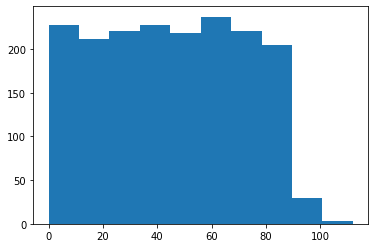

In [31]:
counts, bins = np.histogram(prep_wona['age'].astype(float).astype(int))
plt.hist(bins[:-1], bins, weights=counts)

In [32]:
prep_wona.fillna(value = prep_wona.mean())

,sample_id,age,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2334366,94,0.875,0.312,0.433,0.184,0.538,0.77,0.647,0.213,...,0.297,0.261,0.598,0.54,0.987,0.288,0.585,0.62,0.006,0.75
1,GSM989882,96,0.935,0.43,0.455,0.261,0.539,0.857,0.719,0.278,...,0.15,0.17,0.582,0.418,0.958,0.299,0.029,0.581,0.006,0.847
2,GSM989863,101,0.855,0.33,0.388,0.201,0.496,0.751,0.573,0.15,...,0.121,0.072,0.557,0.373,0.943,0.242,0.541,0.618,0.006,0.835
3,GSM1443696,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
4,GSM1069241,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,GSM2815345,18,0.42,0.035,0.171,0.054,0.63,0.312,0.805,0.412,...,0.08,0.051,0.655,0.471,0.956,0.133,0.472,0.588,0.009,0.843
1798,GSM2814886,18,0.404,0.024,0.173,0.068,0.6,0.347,0.874,0.407,...,0.15,0.025,0.64,0.462,0.948,0.149,0.038,0.594,0.008,0.83
1799,GSM2815335,18,0.441,0.012,0.144,0.06,0.642,0.327,0.919,0.369,...,0.111,0.018,0.639,0.493,0.96,0.159,0.033,0.6,0.008,0.809
1800,GSM2334524,18,0.401,0.019,0.162,0.031,0.596,0.415,0.857,0.277,...,0.085,0.034,0.678,0.513,0.966,0.131,0.535,0.67,0.004,0.889


In [33]:
prep_wona = prep_wona[prep_wona['age'] >= 20]

In [34]:
prep_wona

,sample_id,age,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2334366,94,0.875,0.312,0.433,0.184,0.538,0.77,0.647,0.213,...,0.297,0.261,0.598,0.54,0.987,0.288,0.585,0.62,0.006,0.75
1,GSM989882,96,0.935,0.43,0.455,0.261,0.539,0.857,0.719,0.278,...,0.15,0.17,0.582,0.418,0.958,0.299,0.029,0.581,0.006,0.847
2,GSM989863,101,0.855,0.33,0.388,0.201,0.496,0.751,0.573,0.15,...,0.121,0.072,0.557,0.373,0.943,0.242,0.541,0.618,0.006,0.835
3,GSM1443696,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
4,GSM1069241,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,GSM1498536,48,0.605,0.183,0.263,0.191,0.581,0.479,0.73,0.329,...,0.185,0.038,0.568,0.48,0.963,0.179,0.532,0.599,0.013,0.828
1738,GSM1868331,48,0.68,0.182,0.264,0.068,0.638,0.525,0.756,0.293,...,0.097,0.07,0.687,0.513,0.964,0.183,0.019,0.61,0.011,0.858
1739,GSM2337452,48,0.589,0.191,0.233,0.109,0.671,0.523,0.814,0.336,...,0.11,0.132,0.608,0.504,0.941,0.157,0.524,0.605,0.002,0.845
1740,GSM1653326,48,0.68,0.254,0.343,0.076,0.732,0.48,0.87,0.164,...,0.082,0.227,0.669,0.628,0.947,0.285,0.021,0.597,0.007,0.789


# Preliminary NN Modeling

In [35]:
def generate_test_train(df, test_percentage):
    # generate our X and Y matricies
    X = df.iloc[:, 2:].astype(float)
    # X = X.fillna(value = X.mean())
    Y = df[['age']].astype(float)

    # generate X and Y test train splits
    TEST_SIZE = test_percentage
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = TEST_SIZE, random_state = 2, shuffle=True)
    
    # fill NAs in X_train and X_test with their corresponding column mean
    X_train = X_train.fillna(value = X_train.mean())
    X_test = X_test.fillna(value = X_test.mean())
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    
    return X_train, X_test, Y_train, Y_test

In [88]:
def BuildModel():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu')) 
    model.add(Dense(56, activation='relu')) 
    # model.add(Dense(28,activation='relu')) 
    # model.add(Dense(12,activation='relu')) 
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam")   
    return model

In [57]:
prep_wona

,sample_id,age,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2334366,94,0.875,0.312,0.433,0.184,0.538,0.77,0.647,0.213,...,0.297,0.261,0.598,0.54,0.987,0.288,0.585,0.62,0.006,0.75
1,GSM989882,96,0.935,0.43,0.455,0.261,0.539,0.857,0.719,0.278,...,0.15,0.17,0.582,0.418,0.958,0.299,0.029,0.581,0.006,0.847
2,GSM989863,101,0.855,0.33,0.388,0.201,0.496,0.751,0.573,0.15,...,0.121,0.072,0.557,0.373,0.943,0.242,0.541,0.618,0.006,0.835
3,GSM1443696,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
4,GSM1069241,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,GSM1498536,48,0.605,0.183,0.263,0.191,0.581,0.479,0.73,0.329,...,0.185,0.038,0.568,0.48,0.963,0.179,0.532,0.599,0.013,0.828
1738,GSM1868331,48,0.68,0.182,0.264,0.068,0.638,0.525,0.756,0.293,...,0.097,0.07,0.687,0.513,0.964,0.183,0.019,0.61,0.011,0.858
1739,GSM2337452,48,0.589,0.191,0.233,0.109,0.671,0.523,0.814,0.336,...,0.11,0.132,0.608,0.504,0.941,0.157,0.524,0.605,0.002,0.845
1740,GSM1653326,48,0.68,0.254,0.343,0.076,0.732,0.48,0.87,0.164,...,0.082,0.227,0.669,0.628,0.947,0.285,0.021,0.597,0.007,0.789


In [58]:
np.random.seed(12)
FEATURE_NUM = 100

df = prep_wona.copy()
X_train, X_test, Y_train, Y_test = generate_test_train(df = df, test_percentage = 0.25)

regressor = KerasRegressor(build_fn=BuildModel,epochs=25,batch_size=5)
regressor.fit(X_train,Y_train) 

y_pred = regressor.predict(X_test)


mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE is", mse)
print("rMSE is", rmse)
print("MAE is", mae)

Epoch 1/25
214/214 [==============================] - 0s 805us/step - loss: 1020.5496
Epoch 2/25
214/214 [==============================] - 0s 807us/step - loss: 376.0403
Epoch 3/25
214/214 [==============================] - 0s 791us/step - loss: 234.8291
Epoch 4/25
214/214 [==============================] - 0s 774us/step - loss: 67.5541
Epoch 5/25
214/214 [==============================] - 0s 792us/step - loss: 55.3231
Epoch 6/25
214/214 [==============================] - 0s 793us/step - loss: 43.4396
Epoch 7/25
214/214 [==============================] - 0s 799us/step - loss: 40.7282
Epoch 8/25
214/214 [==============================] - 0s 756us/step - loss: 43.1783
Epoch 9/25
214/214 [==============================] - 0s 749us/step - loss: 41.1620
Epoch 10/25
214/214 [==============================] - 0s 782us/step - loss: 38.1658
Epoch 11/25
214/214 [==============================] - 0s 752us/step - loss: 37.8376
Epoch 12/25
214/214 [==============================] - 0s 777us/step -

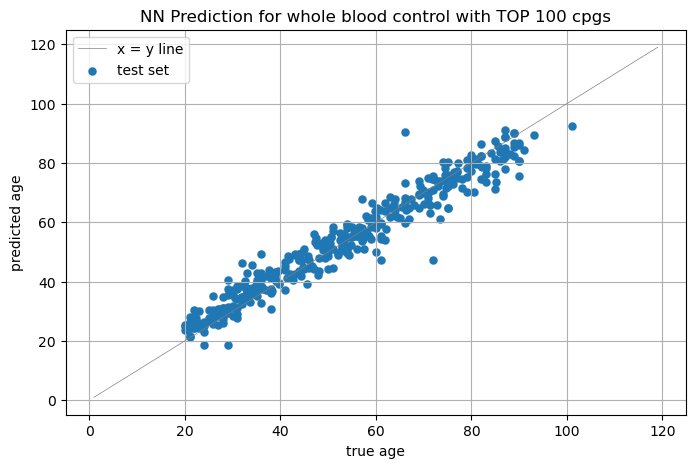

In [59]:
Y_comparison = pd.DataFrame()
Y_comparison['pred'] = y_pred
Y_comparison['true'] = Y_test

x = [i for i in range(1, 120)]
y = [i for i in range(1, 120)]

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(Y_comparison["true"], Y_comparison["pred"], linewidth=0.1, label="test set")
ax.plot(x, y, color = 'grey', linewidth=0.5, label="x = y line")
title = "NN Prediction for " + TISSUE + " control with TOP " + str(FEATURE_NUM) + " cpgs"
ax.set_title(title)
ax.set_ylabel("predicted age")
ax.set_xlabel("true age")
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Best number of cpgs

In [60]:
df

,sample_id,age,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2334366,94,0.875,0.312,0.433,0.184,0.538,0.77,0.647,0.213,...,0.297,0.261,0.598,0.54,0.987,0.288,0.585,0.62,0.006,0.75
1,GSM989882,96,0.935,0.43,0.455,0.261,0.539,0.857,0.719,0.278,...,0.15,0.17,0.582,0.418,0.958,0.299,0.029,0.581,0.006,0.847
2,GSM989863,101,0.855,0.33,0.388,0.201,0.496,0.751,0.573,0.15,...,0.121,0.072,0.557,0.373,0.943,0.242,0.541,0.618,0.006,0.835
3,GSM1443696,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
4,GSM1069241,99,0.731,0.375,0.39,0.212,0.53,0.723,0.354,0.126,...,0.188,0.208,0.557,0.434,0.96,0.183,0.037,0.563,0.005,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,GSM1498536,48,0.605,0.183,0.263,0.191,0.581,0.479,0.73,0.329,...,0.185,0.038,0.568,0.48,0.963,0.179,0.532,0.599,0.013,0.828
1738,GSM1868331,48,0.68,0.182,0.264,0.068,0.638,0.525,0.756,0.293,...,0.097,0.07,0.687,0.513,0.964,0.183,0.019,0.61,0.011,0.858
1739,GSM2337452,48,0.589,0.191,0.233,0.109,0.671,0.523,0.814,0.336,...,0.11,0.132,0.608,0.504,0.941,0.157,0.524,0.605,0.002,0.845
1740,GSM1653326,48,0.68,0.254,0.343,0.076,0.732,0.48,0.87,0.164,...,0.082,0.227,0.669,0.628,0.947,0.285,0.021,0.597,0.007,0.789


In [89]:
# Run linear regression CV=100  nukmber of times for each number of cpgs in the num_cpgs list
# and record metrics.

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

df = prep_wona.copy()

num_cpgs = [10, 20, 30, 50, 100, 200, 300, 400, 500, 600, 700, 782]

mean_mses = []
mean_rmses = []
mean_maes = []
mean_r2s = []
mean_rsquaes = []
std_mses = []
std_rmses = []
std_maes = []
std_r2s = []
std_rsquaes = []
CV = 20
for FEATURE_NUM in num_cpgs:
    print("Now testing cpg number",FEATURE_NUM)
    df_feat = df.iloc[:,:2+FEATURE_NUM]
    mses = []
    rmses = []
    maes = []
    r2s = []
    rsquaes = []
    for i in range(CV):
        if i % 5 == 0:
            print("Trial:",i)
        # train
        X_train, X_test, Y_train, Y_test = generate_test_train(df = df_feat, test_percentage = 0.25)
        regressor = KerasRegressor(build_fn=BuildModel,epochs=20,batch_size=5)
        regressor.fit(X_train,Y_train,verbose=0) 

        # predict
        y_pred = regressor.predict(X_test)

        # test statistics
        mse = mean_squared_error(Y_test, y_pred)
        mae = mean_absolute_error(Y_test, y_pred)
        rmse = np.sqrt(mse)
        
        r2 = r2_score(Y_test, y_pred)
        mses.append(mse)
        rmses.append(rmse)
        maes.append(mae)
        r2s.append(r2)
        
    mean_mses.append(np.array(mses).mean())
    mean_rmses.append(np.array(rmses).mean())
    mean_maes.append(np.array(maes).mean())
    mean_r2s.append(np.array(r2s).mean())
    std_mses.append(np.array(mses).std())
    std_rmses.append(np.array(rmses).std())
    std_maes.append(np.array(maes).std())
    std_r2s.append(np.array(r2s).std())
    print(f'\nThe top {FEATURE_NUM} cpgs where used')
    print(f'mean MSE = {np.array(mses).mean():.3f} ± {np.array(mses).std()/(CV**0.5):.3f} ste')
    print(f'mean rMSE = {np.array(rmses).mean():.3f} ± {np.array(rmses).std()/(CV**0.5):.3f} ste')
    print(f'mean MAE = {np.array(maes).mean():.3f} ± {np.array(maes).std()/(CV**0.5):.3f} ste')
    print(f'mean r2 = {np.array(r2s).mean():.3f} ± {np.array(r2s).std()/(CV**0.5):.3f} ste')

Now testing cpg number 10
Trial: 0
Trial: 5
Trial: 10
Trial: 15

The top 10 cpgs where used
mean MSE = 40.969 ± 0.610 ste
mean rMSE = 6.397 ± 0.046 ste
mean MAE = 4.753 ± 0.044 ste
mean r2 = 0.902 ± 0.001 ste
Now testing cpg number 20
Trial: 0
Trial: 5
Trial: 10
Trial: 15

The top 20 cpgs where used
mean MSE = 36.005 ± 0.302 ste
mean rMSE = 5.999 ± 0.025 ste
mean MAE = 4.381 ± 0.024 ste
mean r2 = 0.914 ± 0.001 ste
Now testing cpg number 30
Trial: 0
Trial: 5
Trial: 10
Trial: 15

The top 30 cpgs where used
mean MSE = 36.070 ± 0.964 ste
mean rMSE = 5.996 ± 0.076 ste
mean MAE = 4.426 ± 0.067 ste
mean r2 = 0.914 ± 0.002 ste
Now testing cpg number 50
Trial: 0
Trial: 5
Trial: 10
Trial: 15

The top 50 cpgs where used
mean MSE = 34.168 ± 0.641 ste
mean rMSE = 5.841 ± 0.053 ste
mean MAE = 4.337 ± 0.042 ste
mean r2 = 0.918 ± 0.002 ste
Now testing cpg number 100
Trial: 0
Trial: 5
Trial: 10
Trial: 15

The top 100 cpgs where used
mean MSE = 33.728 ± 0.936 ste
mean rMSE = 5.797 ± 0.079 ste
mean MAE =

In [90]:
num_s = ['10', '20', '30', '50', '100', '200', '300', '400', '500', '600', '700', '782']

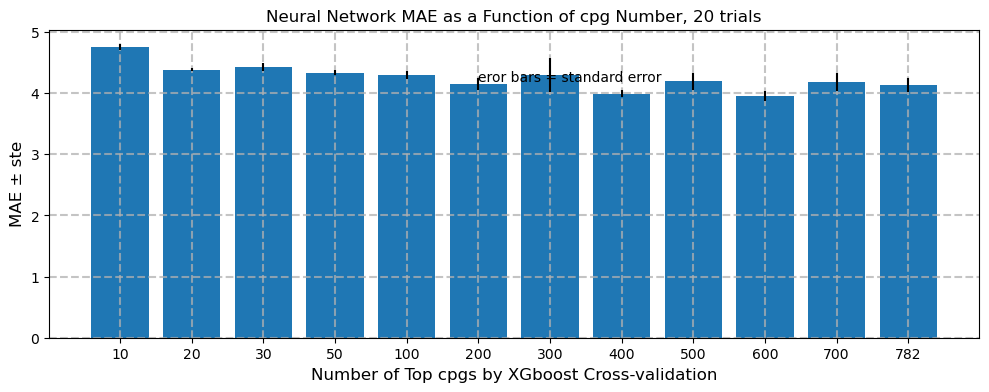

In [91]:
fz = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_maes)/CV**0.5
plt.bar(num_s, mean_maes, yerr = ystes)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.ylabel('MAE ± ste', fontsize = fz)
plt.title(f'Neural Network MAE as a Function of cpg Number, {CV} trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (5, 4.2), fontsize=10)
plt.show()

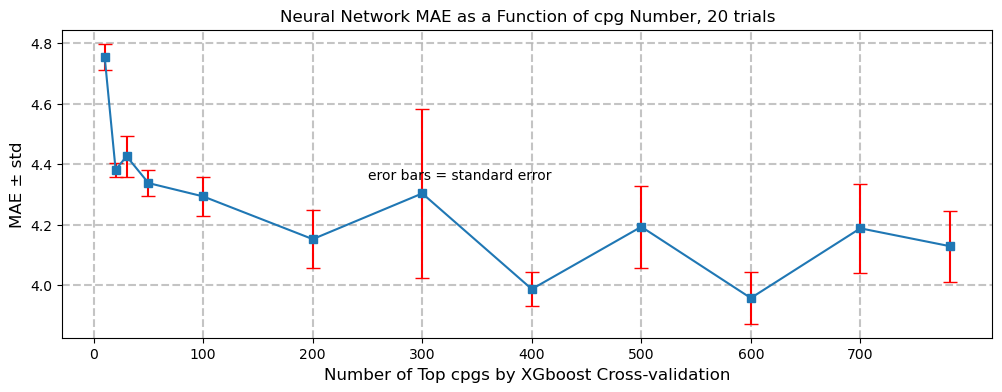

In [92]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_maes)/CV**0.5
plt.errorbar(num_cpgs, mean_maes, marker='s', ecolor='r', yerr = ystes,capsize=5)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.xticks(range(0,800,100))
plt.ylabel('MAE ± std', fontsize = fz)
plt.title(f'Neural Network MAE as a Function of cpg Number, {CV} trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (250, 4.35), fontsize=10)
plt.show()

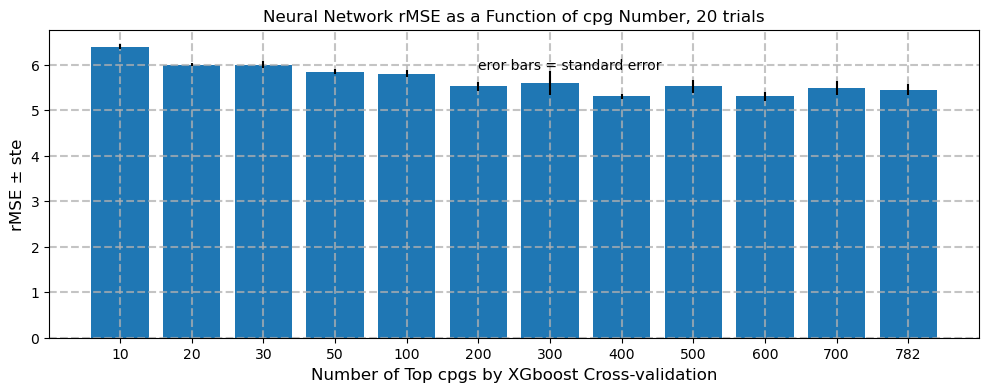

In [93]:
fz = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_rmses)/CV**0.5
plt.bar(num_s, mean_rmses, yerr = ystes)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.ylabel('rMSE ± ste', fontsize = fz)
plt.title(f'Neural Network rMSE as a Function of cpg Number, {CV} trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error ', (5, 5.9), fontsize=10)
plt.show()

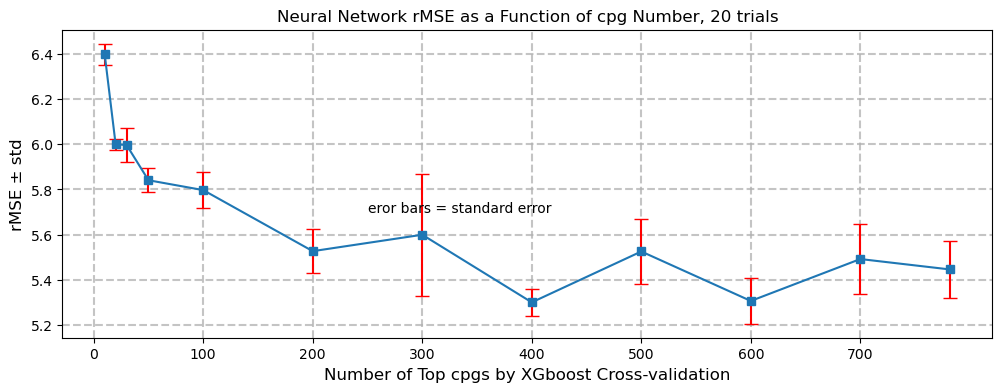

In [94]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_rmses)/CV**0.5
plt.errorbar(num_cpgs, mean_rmses, marker='s', ecolor='r', yerr = ystes,capsize=5)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.xticks(range(0,800,100))
plt.ylabel('rMSE ± std', fontsize = fz)
plt.title(f'Neural Network rMSE as a Function of cpg Number, {CV} trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (250, 5.7), fontsize=10)
plt.show()

### Top 700 features

In [172]:
def BuildModel():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu')) 
    model.add(Dense(64, activation='relu')) 
    # model.add(Dense(28,activation='relu')) 
    # model.add(Dense(12,activation='relu')) 
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam")   
    return model


np.random.seed(12)

df = prep_wona.copy()
FEATURE_NUM = 700

df = df.iloc[:,:2+FEATURE_NUM]
X_train, X_test, Y_train, Y_test = generate_test_train(df = df, test_percentage = 0.25)

bestregressor = KerasRegressor(build_fn=BuildModel,epochs=20,batch_size=5, verbose=False)
bestregressor.fit(X_train,Y_train) 

y_pred = bestregressor.predict(X_test)


mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE is", mse)
print("rMSE is", rmse)
print("MAE is", mae)

MSE is 25.756565090479572
rMSE is 5.075092618906533
MAE is 3.708197186960799


In [173]:
X_test

,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,cg23606718,cg08453194,...,cg00685614,cg23776892,cg06163701,cg05213896,cg18817750,cg01591881,cg01268763,cg16656493,cg12456090,cg09273212
553,0.496,0.217,0.196,0.066,0.616,0.472000,0.759,0.363,0.106,0.472,...,0.906,0.813000,0.968,0.130,0.903,0.897,0.275,0.971,0.013,0.976
1107,0.779,0.275,0.322,0.123,0.520,0.647000,0.677,0.229,0.227,0.372,...,0.979,0.801000,0.972,0.287,0.948,0.853,0.177,0.984,0.012,0.993
732,0.484,0.224,0.164,0.051,0.571,0.541241,0.764,0.294,0.072,0.395,...,0.949,0.609000,0.970,0.265,0.950,0.833,0.262,0.968,0.013,0.988
1266,0.754,0.385,0.318,0.182,0.564,0.706000,0.727,0.275,0.243,0.390,...,0.840,0.836000,0.947,0.372,0.909,0.868,0.170,0.968,0.013,0.987
1374,0.580,0.093,0.225,0.074,0.652,0.456000,0.838,0.361,0.083,0.468,...,0.945,0.813000,0.958,0.231,0.914,0.905,0.161,0.967,0.007,0.992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,0.615,0.108,0.298,0.088,0.637,0.544000,0.640,0.227,0.144,0.418,...,0.813,0.771000,0.949,0.254,0.939,0.858,0.218,0.971,0.016,0.985
1487,0.542,0.068,0.214,0.067,0.650,0.471000,0.837,0.292,0.137,0.466,...,0.944,0.817000,0.947,0.233,0.893,0.880,0.297,0.958,0.014,0.986
512,0.493,0.044,0.130,0.048,0.653,0.438000,0.915,0.358,0.000,0.438,...,0.943,0.805754,0.938,0.000,0.917,0.868,0.276,0.973,0.019,0.983
1316,0.561,0.124,0.224,0.067,0.635,0.446000,0.743,0.338,0.143,0.421,...,0.866,0.830000,0.984,0.189,0.955,0.874,0.280,0.981,0.009,0.989


No handles with labels found to put in legend.


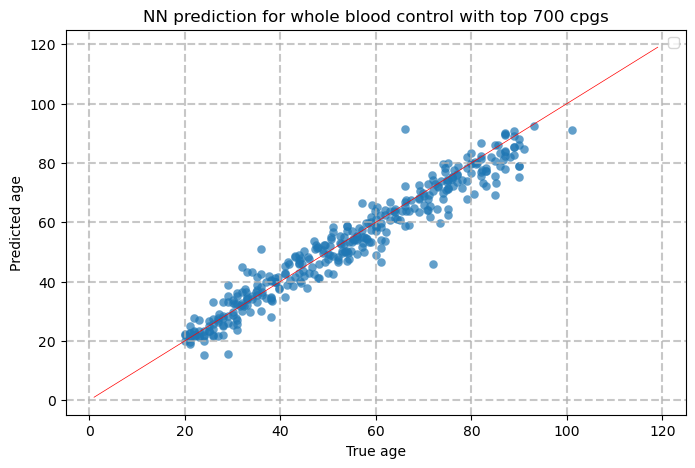

In [174]:
Y_comparison = pd.DataFrame()
Y_comparison['pred'] = y_pred
Y_comparison['true'] = Y_test

x = [i for i in range(1, 120)]
y = [i for i in range(1, 120)]

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(Y_comparison["true"],Y_comparison["pred"], linewidth=0.1, alpha=0.7)
ax.plot(x, y, color = 'red', linewidth=0.5)
title = "NN prediction for " + TISSUE + " control with top " + str(FEATURE_NUM) + " cpgs"
ax.set_title(title)
ax.set_xlabel("True age")
ax.set_ylabel("Predicted age")
plt.legend(loc='best')
plt.grid(True, lw=1.5, ls='--', alpha=0.7)
plt.show()

# Use blood model to predict breast

In [175]:
# getting just the blood data
breast_prep = data[data['tissue'].str.contains('breast')]
breast_prep = breast_prep.reset_index(drop=True)
breast_prep.head()

,sample_id,age,tissue,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM1914667,13,breast,0.284,0.014,0.114,0.013,0.3,0.06,NaN,...,0.039,0.02,0.265,0.292,0.902,0.143,0.422,0.543,0.012,0.781
1,GSM1914655,15,breast,0.479,0.128,0.164,0.035,0.232,0.045,0.247,...,0.085,0.019,0.197,0.245,0.942,0.212,0.422,0.581,0.014,0.837
2,GSM2892522,74,breast,0.651,0.272,0.337,0.09,0.401,0.291,0.517,...,0.148,0.071,0.365,0.339,0.934,0.266,0.541,0.601,0.006,0.874
3,GSM2892579,85,breast,0.659,0.365,0.337,0.107,0.487,0.279,0.643,...,0.12,0.105,0.431,0.267,0.925,0.19,0.519,0.597,0.005,0.861
4,TCGA-AC-A2FM-11B-32D-A19Z-05,87.137,breast,0.748,0.419,0.439,0.135,0.289,0.234,0.336,...,0.238,0.09,0.323,0.336,0.977,0.222,0.555,0.643,0.012,0.884


In [177]:
breast_wona = breast_prep.drop(columns = ['tissue'])

breast_wona.loc[:, breast_wona.columns != 'sample_id'] = breast_wona.loc[:, breast_wona.columns != 'sample_id'].astype(float)
breast_wona = breast_wona[breast_wona['age'] >= 20]

In [178]:
breast_wona = breast_wona.iloc[:,:2+FEATURE_NUM]
breast_wona = breast_wona.reset_index().drop(columns = ['index'])

In [179]:
X_train, X_test, Y_train, Y_test = generate_test_train(df = breast_wona, test_percentage = 1)

In [180]:
X_train

,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,cg23606718,cg08453194,...,cg00685614,cg23776892,cg06163701,cg05213896,cg18817750,cg01591881,cg01268763,cg16656493,cg12456090,cg09273212
199,0.568,0.172,0.233,0.045,0.442,0.081,0.508,0.259,0.029,0.292,...,0.569,0.819,0.948,0.508,0.857,0.947,0.166,0.718,0.005,0.988
478,0.595,0.300,0.180,0.101,0.469,0.438,0.675,0.432,0.217,0.283,...,0.914,0.847,0.892,0.158,0.703,0.902,0.263,0.656,0.004,0.986
437,0.584,0.338,0.266,0.100,0.433,0.213,0.506,0.274,0.195,0.340,...,0.592,0.766,0.885,0.235,0.791,0.931,0.139,0.539,0.009,0.987
463,0.481,0.146,0.168,0.043,0.361,0.097,0.513,0.277,0.155,0.325,...,0.532,0.890,0.903,0.030,0.878,0.958,0.144,0.498,0.010,0.977
154,0.429,0.133,0.113,0.024,0.442,0.133,0.487,0.248,0.059,0.317,...,0.491,0.756,0.869,0.100,0.810,0.940,0.214,0.589,0.010,0.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.709,0.442,0.316,0.159,0.423,0.371,0.547,0.273,0.294,0.330,...,0.577,0.759,0.914,0.417,0.805,0.924,0.276,0.648,0.015,0.991
466,0.631,0.200,0.317,0.035,0.405,0.068,0.510,0.205,0.038,0.296,...,0.575,0.787,0.930,0.405,0.847,0.969,0.158,0.645,0.014,0.996
299,0.623,0.348,0.355,0.096,0.346,0.207,0.446,0.122,0.199,0.246,...,0.561,0.802,0.936,0.362,0.917,0.924,0.184,0.635,0.007,0.996
493,0.567,0.376,0.266,0.105,0.279,0.142,0.382,0.220,0.141,0.221,...,0.401,0.763,0.872,0.358,0.817,0.959,0.162,0.575,0.009,0.988


In [182]:
y_pred = bestregressor.predict(X_train)

mse = mean_squared_error(Y_train, y_pred)
mae = mean_absolute_error(Y_train, y_pred)
rmse = np.sqrt(mse)

print("MSE is", mse)
print("rMSE is", rmse)
print("MAE is", mae)

MSE is 192.5255806703135
rMSE is 13.875358758256073
MAE is 11.068156715166683


No handles with labels found to put in legend.


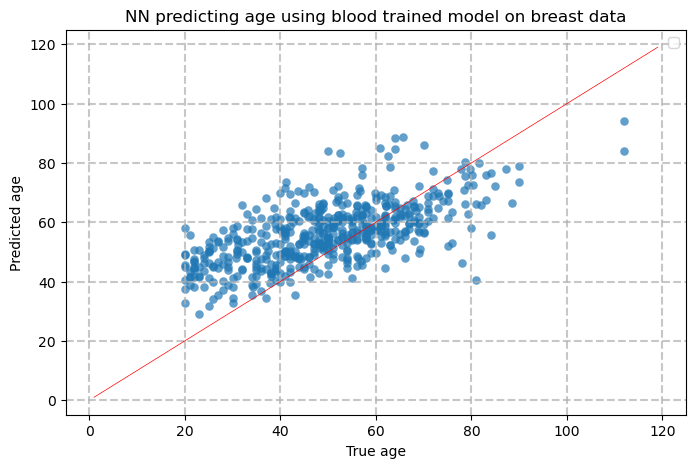

In [184]:
Y_comparison = pd.DataFrame()
Y_comparison['pred'] = y_pred
Y_comparison['true'] = Y_train

x = [i for i in range(1, 120)]
y = [i for i in range(1, 120)]

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(Y_comparison["true"],Y_comparison["pred"], linewidth=0.1, alpha=0.7)
ax.plot(x, y, color = 'red', linewidth=0.5)
title = "NN predicting age using blood trained model on breast data"
ax.set_title(title)
ax.set_xlabel("True age")
ax.set_ylabel("Predicted age")
plt.legend(loc='best')
plt.grid(True, lw=1.5, ls='--', alpha=0.7)
plt.show()

# Use blood model to predict brain

In [185]:
brain_prep = data[data['tissue'].str.contains('brain')]
brain_prep = brain_prep.reset_index(drop=True)
brain_prep.head()

,sample_id,age,tissue,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,...,cg12892303,cg21159778,cg26671246,cg13700939,cg11150667,cg12377139,cg04149024,cg06857049,cg27479134,cg25955850
0,GSM2139432,71,brain - superior temporal gyrus,0.527,0.509,0.257,0.04,0.352,0.299,0.356,...,0.179,0.023,0.552,0.429,0.785,0.137,0.042,0.613,0.009,0.87
1,GSM2139249,76,brain - superior temporal gyrus,0.571,0.543,0.282,0.058,0.393,0.413,0.357,...,0.19,0.049,0.558,0.447,0.728,0.175,0.512,0.617,0.01,0.905
2,GSM2139398,102,brain - superior temporal gyrus,0.57,0.545,0.278,0.068,0.354,0.395,0.329,...,0.131,0.015,0.541,0.438,0.815,0.217,0.489,0.632,0.01,0.886
3,GSM2139297,108,brain - superior temporal gyrus,0.552,0.559,0.277,0.099,0.383,0.438,0.423,...,0.173,0.077,0.537,0.422,0.792,0.218,0.501,0.634,0.007,0.891
4,GSM1069208,40,brain - superior temporal gyrus,0.44,0.448,0.131,0.042,0.392,0.212,0.493,...,0.116,0.043,0.538,0.361,0.809,0.119,0.044,0.641,0.002,0.891


In [186]:
brain_wona = brain_prep.drop(columns = ['tissue'])

brain_wona.loc[:, brain_wona.columns != 'sample_id'] = brain_wona.loc[:, brain_wona.columns != 'sample_id'].astype(float)
brain_wona = brain_wona[brain_wona['age'] >= 20]

In [187]:
brain_wona = brain_wona.iloc[:,:2+FEATURE_NUM]
brain_wona = brain_wona.reset_index().drop(columns = ['index'])

In [188]:
X_train, X_test, Y_train, Y_test = generate_test_train(df = brain_wona, test_percentage = 1)

In [189]:
X_train

,cg16867657,cg04875128,cg07553761,cg00292135,cg04208403,cg22454769,cg19344626,cg02046143,cg23606718,cg08453194,...,cg00685614,cg23776892,cg06163701,cg05213896,cg18817750,cg01591881,cg01268763,cg16656493,cg12456090,cg09273212
1096,0.605,0.575,0.323,0.113,0.343,0.434,0.35700,0.734,0.193,0.207,...,0.233,0.798,0.575,0.340,0.736,0.814,0.062,0.641,0.007,0.986
505,0.329,0.429,0.166,0.016,0.298,0.237,0.36632,0.575,0.112,0.288,...,0.384,0.850,0.707,0.119,0.523,0.696,0.080,0.641,0.014,0.991
717,0.693,0.576,0.347,0.094,0.384,0.551,0.23400,0.771,0.241,0.205,...,0.286,0.725,0.467,0.278,0.803,0.916,0.040,0.577,0.005,0.986
1171,0.465,0.378,0.175,0.037,0.387,0.286,0.62200,0.619,0.120,0.222,...,0.500,0.819,0.863,0.160,0.624,0.813,0.041,0.659,0.005,0.990
508,0.366,0.437,0.122,0.017,0.338,0.183,0.37500,0.709,0.052,0.213,...,0.293,0.734,0.592,0.138,0.570,0.758,0.053,0.604,0.014,0.979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,0.450,0.485,0.132,0.047,0.386,0.210,0.60400,0.682,0.098,0.318,...,0.434,0.813,0.848,0.153,0.607,0.735,0.084,0.642,0.009,0.992
299,0.187,0.416,0.114,0.039,0.088,0.286,0.09900,0.265,0.044,0.130,...,0.027,0.785,0.662,0.110,0.836,0.917,0.044,0.582,0.013,0.975
493,0.491,0.515,0.270,0.046,0.337,0.359,0.40500,0.630,0.110,0.278,...,0.358,0.715,0.595,0.239,0.615,0.755,0.081,0.641,0.005,0.984
527,0.361,0.473,0.115,0.041,0.377,0.140,0.50200,0.732,0.062,0.281,...,0.391,0.806,0.793,0.103,0.615,0.760,0.124,0.689,0.010,0.990


In [192]:
y_pred = bestregressor.predict(X_train)

mse = mean_squared_error(Y_train, y_pred)
mae = mean_absolute_error(Y_train, y_pred)
rmse = np.sqrt(mse)

print("MSE is", mse)
print("MAE is", mae)
print("rMSE is", rmse)

MSE is 1080.6834192111128
MAE is 29.15889871584238
rMSE is 32.87374969806628


No handles with labels found to put in legend.


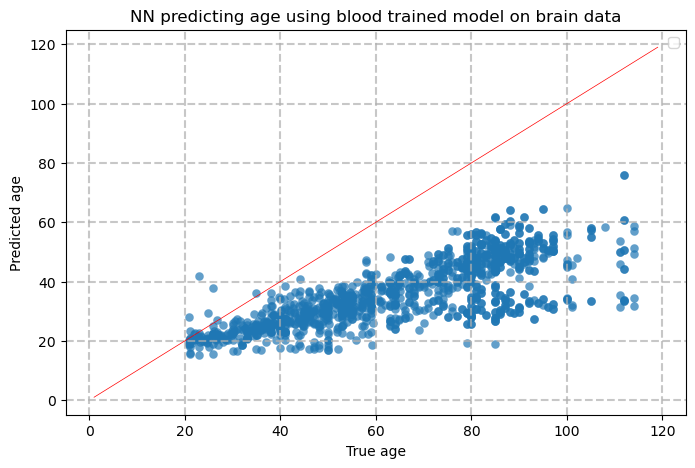

In [191]:
Y_comparison = pd.DataFrame()
Y_comparison['pred'] = y_pred
Y_comparison['true'] = Y_train

x = [i for i in range(1, 120)]
y = [i for i in range(1, 120)]

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(Y_comparison["true"],Y_comparison["pred"], linewidth=0.1, alpha=0.7)
ax.plot(x, y, color = 'red', linewidth=0.5)
title = "NN predicting age using blood trained model on brain data"
ax.set_title(title)
ax.set_xlabel("True age")
ax.set_ylabel("Predicted age")
plt.legend(loc='best')
plt.grid(True, lw=1.5, ls='--', alpha=0.7)
plt.show()